In [2]:
#!unzip "drive/MyDrive/Colab Notebooks/DogVision/dog-breed-identification.zip"  -d "drive/MyDrive/Colab Notebooks/DogVision"

# The Multiclass Dog Breed Prediction
This will be a multiclass image classifier which will be made using `tensorflow` and `tensorflow.hub` 

### Getting our Data Ready

We first need to import tensorflow to our colab notebook

In [3]:
import tensorflow as tf
print("Current Version: ", tf.__version__)

Current Version:  2.8.2


Hence, the current version of tensorflow is 2.8, which is latest.

Now, we will be importing `tensorflow hub` 

**TensorFlow Hub**: A repository that containes pre-trained models to use.
The models include image preprocessors and text embedders.

Have a look at the given link 
https://tfhub.dev/

In [4]:
import tensorflow_hub as hub
print("Version of tensorflow Hub", hub.__version__)

# Also check the GPU avalibility.
print("Yes there is a GPU" if tf.config.list_physical_devices("GPU") else print("Not avalible"))

Version of tensorflow Hub 0.12.0
Yes there is a GPU


Clearly, now we have tensorflow and tensorflow hub with us now. But where is the GPU???

Go to runtime and change the type to GPU and now run the commands


In [5]:
# checking the GPU avalibility once more.
print("Yes there is a GPU" if tf.config.list_physical_devices("GPU") else print("Not avalible"))

Yes there is a GPU


Now that we have our GPU and necessary tools imported, we will now be importing our Kaggle dataset and then convert the images to `tensors`

**Tensors**: The tensors are n-dimensional arrays of base datatype. The difference between them and numpy arrays is that tensors can be run on a `GPU`

In [6]:
# Let us start this by accessing out labels dataset
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DogVision/labels.csv")
print(labels_csv.describe())  # describe function returns the description of data in the dataframe 
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


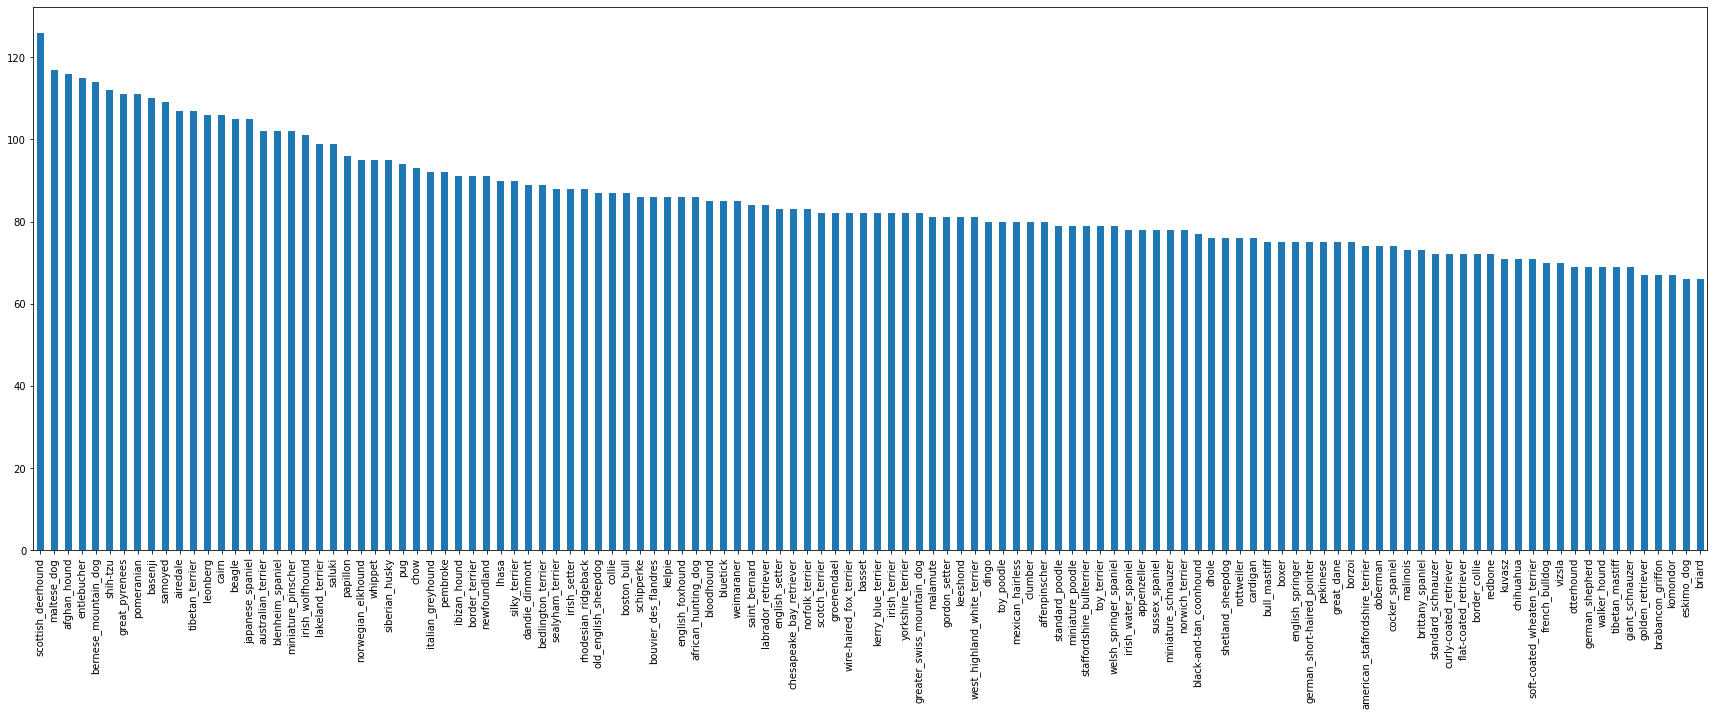

In [7]:
labels_csv["breed"].value_counts().plot.bar(figsize = (30,10))
# visualizing the number of dogs in each breed by plotting the value counts of the breeds


# Preparing the Images
Now, we need to preprocess the images so as to use it to train our model

But, first let us view an image

### View an image


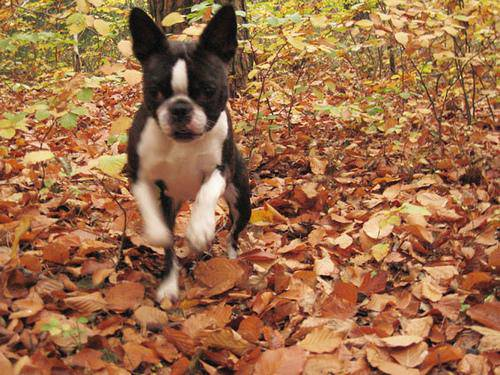

In [8]:
# for this purpose, we will be using Ipython
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")
# This is a random image which has been displayed

### Getting images into a list

Obviously, we don't want to get all this everytime. So we will be creating a list which will contain all the images so that the access to an image becomes easy

In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Creating the pathnames from image id's
# filenames = [fname for fname in labels_csv["id"]]
filenames = ["/content/drive/MyDrive/Colab Notebooks/DogVision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# check some of the items of the list
filenames[:5]

['/content/drive/MyDrive/Colab Notebooks/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/DogVision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/DogVision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/DogVision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

Just for the precaution, we will be testing if all the photos of the train folder are in the list or not. This will happen when the length of the list will be equal to the total files in the dorectory..

To find the number of items in the directory, we need to `import os` and use the function `os.listdir`

In [11]:
import os
if (len(os.listdir("/content/drive/MyDrive/Colab Notebooks/DogVision/train/")) == len(filenames)):
  print("You may proceed as the filenames list containes all the elements")
else:
  print("Check again")


You may proceed as the filenames list containes all the elements


Just for fun, check any one image

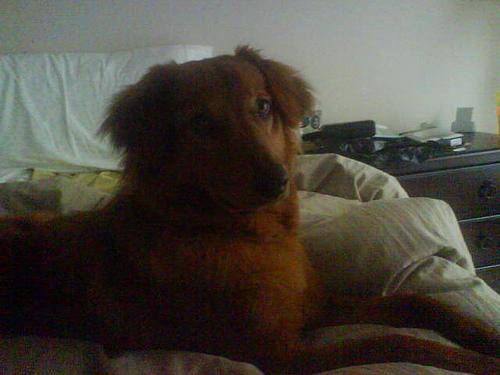

In [12]:
Image(filenames[1000])

### Now, we will process our labels

For this, we will convert the `["breed"]` dataframe from labels_csv to a normal numpy array by using `.to_numpy()`

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels[:5]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

In [14]:
# now for precaution, we will check if the number of elements of the list is equal to the number of elements of filename
if len(labels) == len(filenames):
  print("Yes, the labels list and the filenames list are of equal length. You may proceed further")

else:
  print("Move Back and check")

Yes, the labels list and the filenames list are of equal length. You may proceed further


Labels are currently the array of string values and we know that an ML model cannot take string as input, so we will convert the string to numbers

 Also, the labels contain all breeds multiple times, as they correspond to every image of the dataset. Hence we need to first return the unique valeus from the list 

In [15]:
unique_breeds = np.unique(labels)

In [16]:
len(unique_breeds)

120

In [17]:
unique_breeds[0]

'affenpinscher'

`Hence verified`

We now need to convert the single `labels` into array of booleans, because the ML model accepts the numerical values  

In [18]:
print(labels[0])
labels[0] == unique_breeds # Wherever the labels index matches the unique_breeds index, True will be printed

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Seeing the above example, now we will be converting all the list into boolean arrays
boolean_labels = [labels == unique_breeds for labels in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

These boolean arrays will now be converted to numeric values using `one hot encoding`

In [20]:
# Example of converting our boolean array into numbers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # index where the labels occur
print(boolean_labels[0].argmax()) # index where the labels occur in boolean array .argmax() is used to return the index of maximum value in an array
print(boolean_labels[0].astype(int)) # to get 1 where the sample label occurs
# 19th value containes a 1 according to this code

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own validation set.
The Kaggle dataset which we are working on does not comes with the validation set.
 

In [21]:
# Setup X and Y variables
X = filenames
Y = boolean_labels

our main target is to conduct the experiments in misimum amount of time in order to get perfect scores in less time..so we are going to start with 1000~ images and then we will increase them according to our needs

In [22]:
# Setting up the number of images
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:100}

Let us now split our data into training set and validation set.
This will be done by using sklearn's train test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X[:NUM_IMAGES],
                                                      Y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)

In [24]:
len(X_train)

800

And the rest of 200 are in validation set

# Image Preprocessing
Here, we will be turning our images into tensors

In [25]:
# We will define some functions to make our task easier

In [26]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

The shape is of the format `(height, width, colour channel)`

**Colour channel**:RGB and the values range from 0 to 255 

Now, we will convert the image into tensors `tf.constant(image)` will be used here

In [27]:
image[:2],
print(" ")
print("Now, Converting them to tensors")
print(" ")
tf.constant(image)[:2]


 
Now, Converting them to tensors
 


<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

### The preprocessor Function

Our Function will be able to do the following tasks

1. Take image filepath as input.
2. Use tensorflow to read the file path and store it into a variable (image).
3. Turn our image to tensors and resize it to `(224,224)` ->> shape.
4. `Normalization` of the image to convert it's color channels from value of 0-255 to tha value of 0-1.
4. Return modified image.

In [28]:
IMG_SIZE = 224

# Creating the preprocessor function
def process_image(image_path):
  """
  Takes the file path and converts that into a tensor
  """

  # Read the image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg channel into a numeric channel whit three colour channels. RGB
  image = tf.image.decode_jpeg(image, channels=3)

  # Now, convert the colour channels value from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Above process is known as normalization. This is done in order for us to make the image processing by machine easier

  # Resize the image to desired value
  image =tf.image.resize(image,size=[IMG_SIZE, IMG_SIZE])

  return image

# Converting our Data into Batches


A good Batch size is 32

Suppose you process 10,000 images in one go. This might work, but it is not a good habit. 32 (i.e. the batch size) is the descent one for processing our images

In order to use tensorflow effectively, we need our data to be in form of tensorflow tuples of the form `(images, labels)`

In [29]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [30]:
# Demo of above function
get_image_label(X[40], tf.constant(Y[40]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.99609005, 0.96119833, 0.95770377],
         [0.98501533, 0.94666374, 0.93379605],
         [0.99749774, 0.9770274 , 0.9565523 ],
         ...,
         [0.34569168, 0.5497533 , 0.22850783],
         [0.4276134 , 0.6322353 , 0.33483163],
         [0.36833197, 0.5772412 , 0.29097825]],
 
        [[0.9687435 , 0.965289  , 0.9172323 ],
         [0.94134724, 0.93233955, 0.8760108 ],
         [0.92182285, 0.9180851 , 0.8512452 ],
         ...,
         [0.36644298, 0.57037514, 0.24943131],
         [0.36225268, 0.5662274 , 0.2703323 ],
         [0.34930357, 0.5534058 , 0.27435333]],
 
        [[0.82989013, 0.87487435, 0.75133675],
         [0.7506709 , 0.7958162 , 0.66784185],
         [0.75523835, 0.8078179 , 0.67545015],
         ...,
         [0.40426058, 0.60512996, 0.2932135 ],
         [0.35947898, 0.55773896, 0.2682605 ],
         [0.38644102, 0.5856088 , 0.3115852 ]],
 
        ...,
 
        [[0.45484307, 0.5300532 

Now we have our data in form of `(image, labels)` tuple, but our label is not really a tensor, we have converted it while calling the function

In [31]:
# BATCH_SIZE = 32
# # we need to define valid data and test data so that they can be processed insode the  
# def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
#   """
#   Creates the batches out of the image X and label Y pairs.
#   Shuffles the data if it is training data, but does not shuffles the validation data.
#   Also accepts the data as inputs, not labels
#   """

#   # If data is the test data, we probably don't need to have labels
#   if test_data:
#     print("Creating the test batches")
#     data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only image, not labels
#     # convert into a batch of 32
#     data_batch = data.map(process_image).batch(BATCH_SIZE) #because, the labels are not required
#     return data_batch

#   # If the data is validation data, we probably don't need to shuffle it
#   if valid_data:
#     print("Creating the valid batches")
#     data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(Y)))
#     data_batch = data.map(get_image_label).batch(BATCH_SIZE) #because, the labels are required
#     return data_batch

#   # otherwise, it is a training dataset and we need to shuffle it
#   else:
#     print("Creating the training batch")
#     data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y))) 
    
#     # Shuffeling the pathnames and the labels before mapping image processor is faster than shuffeling the images
#     # this is because, the shuffeling of file path is easier than shuffeling the full images
#     data = data.shuffle(buffer_size=len(X))
#     data = data.map(get_image_label)
#     data_batch = data.batch(BATCH_SIZE) #because, the labels are required
#     return data_batch
    
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [32]:
train_data = create_data_batches(X_train, Y_train)
val_data = create_data_batches(X_train, Y_train, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [33]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

 Let us check out the different attributes of our data batches

for this, `variable.element_spec` function will be used

In [34]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualizing the Data-Batches

It is hard tu understand the data in this format. We therefore, need a function to visualize a batch  

In [35]:
# import matplotlib.pyplot as plt

# def show_25_images(images, labels):
#   """
#   Displays the plot of 25 images and their labels from a data batch
#   """
#   # Setup the figure
#   plt.figure(figsize=(10, 10))

#   # Loop through 25 to display 25 images
#   for i in range(25):
#     #Create subplots of 5 rows and 5 columns
#     ax = plt.subplot(5,5,i+1)

#     # Display an image
#     plt.imshow(images[i])

#     # Add image labels
#     plt.title(unique_breeds[labels[i]].argmax())

#     # Turn the grid lines off
#     #plt.axis("OFF")

import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

`train_data` is in the form of a batch, so in order to plot it, we need to unbatch it

In [36]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

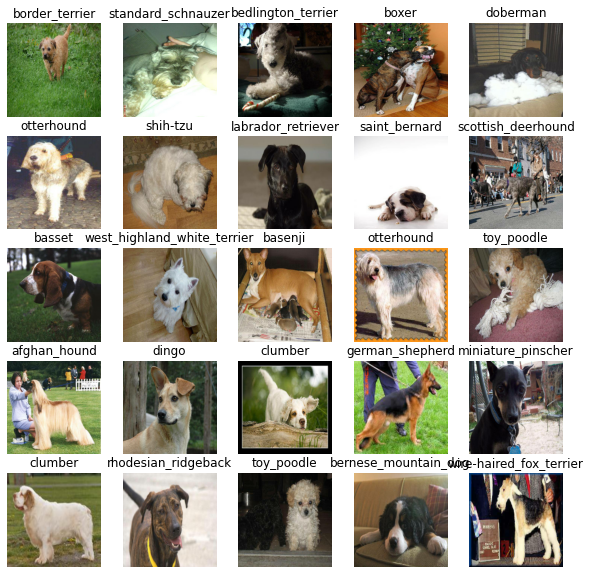

In [38]:
# Now, let us visualize the datain our training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

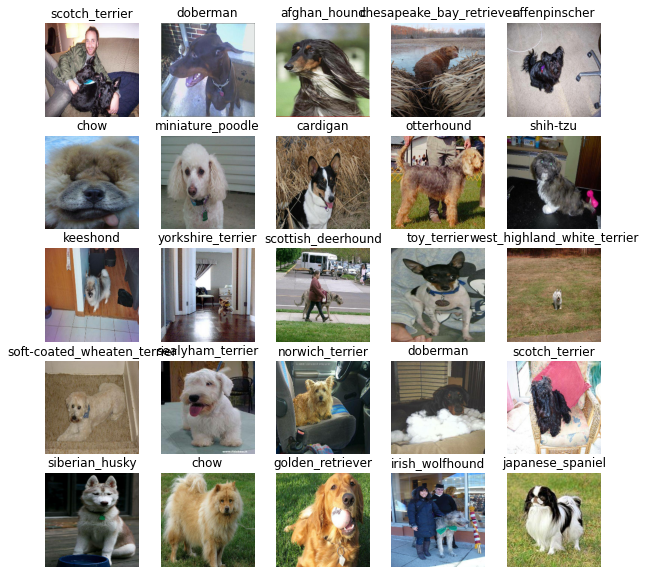

In [39]:
# Visualizing our validaion set
val_images, val_labels = next(train_data.as_numpy_iterator()) # turned our batch into a numpy iterator
show_25_images(val_images, val_labels)

# Building a model by using pre-existing model


 In order to build the model, we require 3 things
 
 * Define Input shape to our model
 * Define the output shape to our model
 * URL of the model we want to use 

In [40]:
# Define the input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the output shape
OUTPUT_SHAPE = len(unique_breeds)

# Setup the model URL

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Now we have our input, output and model ready to go. We can now put them together into a Keras deep learning model

Knowing this, let us create a function which:
* Takes the input shape, output shape and model we have chosen as parameters
* Define the layers in keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (sys how it should be evaluated and improves).
* Build the model.
* Returns the model.

In [41]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building the model with", MODEL_URL)

  # Setup model layer
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Input Layer
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Output Layer (Sigmoid for binary classification)
])
  
  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(), # How well the model is guessing? (Binary crossentropy for binary classification)
      optimizer=tf.keras.optimizers.Adam(), # Improvement in the guesses
      metrics=["accuracy"] # Evaluation
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model


In [42]:
model = create_model()
model.summary()

Building the model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


# Creating Callbacks

Callbacks are the helper functions a model can use during the training so as to perform the tasks such as save the progress, check it's progress or stop training early if the model stope improving

We'll create two callbacks, one for TensorBoard which helps us to track the model progressand another for early stopping which prevents our model from training for too long

### TensorBoard Callback


In order to setup a TensorBoard callback, we need to do 3 things:
1. Load the tensor board notebook extension
2. Create a tensorboard callback which is able to save logs to a directory and pass it to our model's `fit()` function
3. Visualize our model's training logs with the `%tensorboard` magic function.

In [43]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [50]:
import datetime
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():

  # Create a log directory for storing tensor board logs
  logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/logs", datetime.datetime.now().strftime("%Y%M%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

This will help our model from overfitting by stopping if a certain evalation meteric stops working

In [51]:
# Create early stopping callback
early_stopping  = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=0,)

# Training the **Model**

Our first model is only going to train on 1000 images, ti make sure everything is working. 

In [52]:
NUM_EPOCHS = 10 #@param{type: "slider", min:10, max:100, step:10}

In [53]:
# Precautionary check
print("Yes there is a GPU" if tf.config.list_physical_devices("GPU") else print("Not avalible"))

Yes there is a GPU


 Let us create a function which trains a 
 
 * Create the model using `create_model()`
 * Setup a TensorBoard callback using `create_tensorboard_callback()`
 * Call the `fit()` function on our model passing it in training and the validation data along with the number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
 * Return the model


In [54]:
 # Build a function to train and return a trained model
# def train_model():
  
#   """
#   Trains a given model and returns the trained version
#   """

#   # Create the model
#   model = create_model()

#   # Create new TensorBoard session everytime we train the model
#   tensorboard = create_tensorboard_callback()

#   # Fit the model to the data passing it the callbacks we created
#   model.fit(x = train_data,
#                 epochs=NUM_EPOCHS,
#                 validation_data=val_data,
#                 validation_freq=1,
#                 callbacks =[tensorboard, early_stopping])
  
#   # Return the fitted model
#   return model_selection


# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [55]:
model = train_model()

Building the model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10
25/25 [==============================] - 76s 2s/step - loss: 4.4842 - accuracy: 0.0862 - val_loss: 2.2719 - val_accuracy: 0.5325
Epoch 2/10
25/25 [==============================] - 5s 197ms/step - loss: 1.5790 - accuracy: 0.6862 - val_loss: 0.7180 - val_accuracy: 0.9150


### Checking the tensorboard logs

The tensorboard magic function `%tensorboard` helps us to access the logs directory we created earlier and visualize it's contents

In [66]:
# %tensorboard --logdir /drive/MyDrive/Colab\ Notebooks/logs

### Making and evaluating the predictions using an already trained model

In [69]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

25/25 [==============================] - 5s 183ms/step


array([[2.7653067e-03, 2.0976753e-04, 5.3694621e-03, ..., 7.5688842e-04,
        5.4260524e-04, 9.0332152e-03],
       [1.1000319e-03, 5.8692424e-03, 1.1579807e-05, ..., 9.6223484e-05,
        5.2820082e-04, 2.3156148e-04],
       [2.3792887e-03, 5.4193195e-04, 8.0765647e-05, ..., 1.8367080e-04,
        1.0752246e-04, 3.7588286e-03],
       ...,
       [1.1926752e-03, 4.0372442e-02, 3.1752346e-04, ..., 4.5597102e-04,
        1.0892014e-04, 1.6788808e-03],
       [1.1616726e-02, 2.6775226e-03, 4.1592485e-04, ..., 7.6180568e-04,
        8.9188205e-04, 1.1039490e-02],
       [5.4738997e-04, 1.1079378e-03, 3.8563737e-04, ..., 7.8700222e-03,
        8.2540952e-02, 8.8310357e-05]], dtype=float32)

In [70]:
predictions.shape

(800, 120)

In [71]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[2.7653067e-03 2.0976753e-04 5.3694621e-03 3.7466531e-04 9.3287375e-04
 3.5055351e-04 3.6469083e-03 8.9318166e-04 1.5377429e-03 1.2832556e-03
 9.4126957e-04 7.3506928e-04 7.3868764e-04 1.5786046e-03 6.8490091e-04
 1.5998897e-04 1.4397394e-03 4.3739140e-02 1.6364373e-03 2.8898485e-04
 6.9871551e-04 4.3800581e-04 6.9585862e-04 4.7760969e-04 5.3295237e-04
 6.5080106e-04 6.9458574e-01 1.0498684e-03 8.2684455e-05 1.7715035e-03
 2.0022722e-04 4.1767410e-03 5.7747448e-04 7.8722747e-04 4.1187214e-04
 1.6284229e-03 3.8169112e-04 7.6122605e-03 2.5486873e-04 2.0968552e-04
 5.7441118e-04 8.1884238e-04 6.5976637e-04 5.1583146e-04 8.0034428e-04
 4.7354476e-04 6.9007650e-03 1.7114343e-04 1.2822411e-03 4.3282815e-04
 2.2677492e-04 6.8877725e-04 4.9803278e-04 1.7014520e-03 1.5311299e-03
 1.6756660e-04 3.0376675e-04 4.7904546e-03 1.0170361e-04 8.0572162e-03
 2.0933617e-03 1.2425611e-04 1.1970628e-03 1.6623136e-04 1.5750970e-03
 6.9415988e-04 1.1931261e-03 1.7766298e-03 1.4145597e-03 1.3280600e-04
 1.531

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

In [72]:
# Turn the prediction probabilities into their respective label
def get_pred_label(prediction_proboabilities):
  """
  Turns the array of prediction probabilites into labels
  """

  return unique_breeds[np.argmax(prediction_proboabilities)]

In [74]:
# Demo of the above function
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

 Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the fit() function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using unbatch()) and then turn it into an iterator using as_numpy_iterator().

Let's make a small function to do so.

In [77]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.04452813, 0.0484497 , 0.05629283],
         [0.05633019, 0.06025176, 0.06809489],
         [0.04290967, 0.04683124, 0.05467437],
         ...,
         [0.07345551, 0.02696446, 0.0128119 ],
         [0.08338569, 0.06167922, 0.02458122],
         [0.09094839, 0.07918368, 0.04653312]],
 
        [[0.03778223, 0.04562537, 0.04161626],
         [0.0300378 , 0.03788094, 0.03387184],
         [0.07026608, 0.07810921, 0.07410011],
         ...,
         [0.2120701 , 0.20385231, 0.15405536],
         [0.06193235, 0.04972087, 0.03209355],
         [0.01333135, 0.00152287, 0.00104142]],
 
        [[0.08905759, 0.1049627 , 0.08513602],
         [0.09621842, 0.11212353, 0.09229685],
         [0.05104753, 0.06695264, 0.04712596],
         ...,
         [0.17335822, 0.20798706, 0.14030793],
         [0.3077376 , 0.30949864, 0.20433936],
         [0.37611565, 0.36580402, 0.250109  ]],
 
        ...,
 
        [[0.42239693, 0.37925968, 0.25376946],
         [0.5056203 , 0.4401441 , 0.32190

Nailed it!

Now we've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images
* Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [78]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

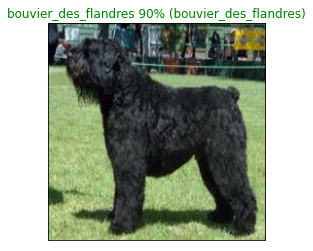

In [79]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)


Nice! Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:

Take an input of a prediction probabilities array, a ground truth labels array and an integer.
Find the predicted label using get_pred_label().
Find the top 10:
Prediction probabilities indexes
Prediction probabilities values
Prediction labels
Plot the top 10 prediction probability values and labels, coloring the true label green.

In [80]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

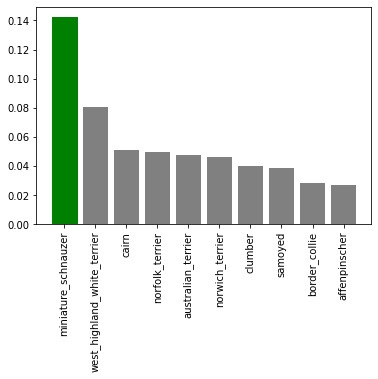

In [81]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

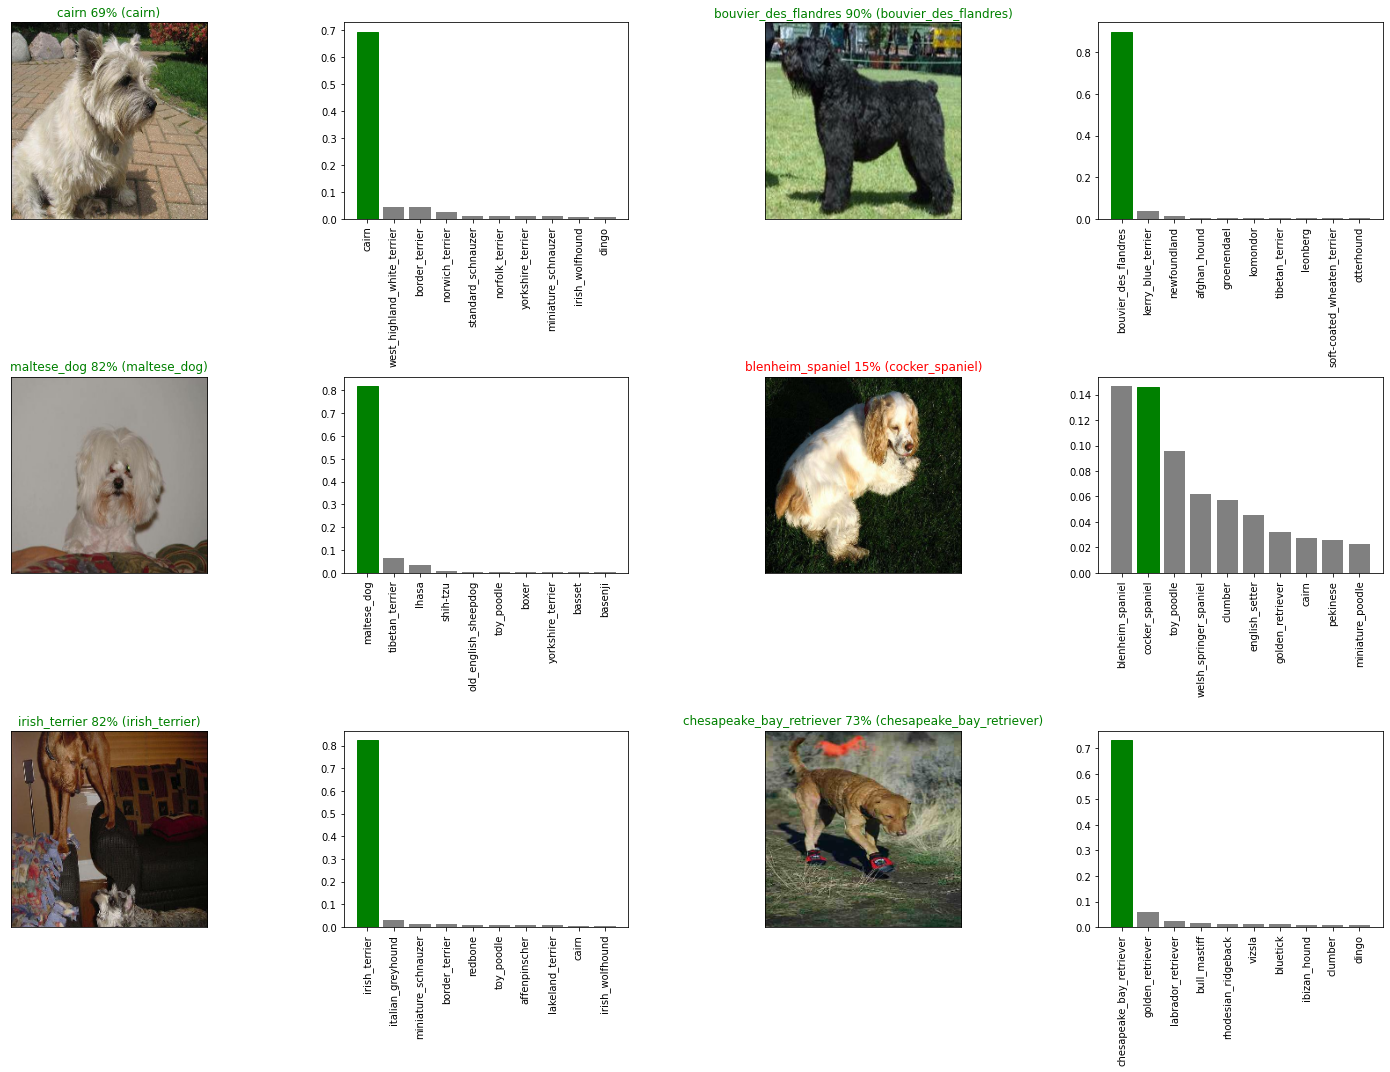

In [82]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Save the Current model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an entire saved Keras model is h5. So we'll make a function which can take a model as input and utilise the save() method to save it as a h5 file to a specified directory.

In [84]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Colab Notebooks/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [85]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model


# Training the data 

In [89]:
full_model = create_model()
full_data = create_data_batches(X, Y)

Building the model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Creating training data batches...


In [90]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [91]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/10
320/320 [==============================] - 847s 3s/step - loss: 1.3354 - accuracy: 0.6734
Epoch 2/10
320/320 [==============================] - 34s 105ms/step - loss: 0.3974 - accuracy: 0.8829
Epoch 3/10
320/320 [==============================] - 32s 100ms/step - loss: 0.2345 - accuracy: 0.9342
Epoch 4/10
320/320 [==============================] - 31s 95ms/step - loss: 0.1522 - accuracy: 0.9625
Epoch 5/10
320/320 [==============================] - 32s 100ms/step - loss: 0.1044 - accuracy: 0.9790
Epoch 6/10
320/320 [==============================] - 31s 95ms/step - loss: 0.0763 - accuracy: 0.9873
Epoch 7/10
320/320 [==============================] - 32s 101ms/step - loss: 0.0575 - accuracy: 0.9926
Epoch 8/10
320/320 [==============================] - 31s 95ms/step - loss: 0.0466 - accuracy: 0.9938
Epoch 9/10
320/320 [==============================] - 32s 101ms/step - loss: 0.0375 - accuracy: 0.9957
Epoch 10/10
320/320 [==============================] - 32s 100ms/step - loss: 

In [110]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/Colab Notebooks/models/20220822-22361661207795-all-images-Adam.h5')

Saving model to: drive/MyDrive/Colab Notebooks/models/20220822-22381661207904-all-images-Adam.h5...
Loading saved model from: /content/drive/MyDrive/Colab Notebooks/models/20220822-22361661207795-all-images-Adam.h5


# Make predictions on test dataset

1.   List item
2.   List item



Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created create_data_batches() earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:

Get the test image filenames.
Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since there are no labels with the test images).
Make a predictions array by passing the test data batches to the predict() function.

In [128]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/MyDrive/Colab Notebooks/DogVision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['drive/MyDrive/Colab Notebooks/DogVision/test/e4e991c432ce6d8e8ba26672ff8fb2f5.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/dfdeddf3da8d52c211620eaabd82b773.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/df7d17082d1b25eeba9be835a150db01.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/e24b2d063b3ad699d5eba7a01e4ae956.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/e51de127ddf2c492372a63f0644b1a58.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/e1b0cbcf3235fe9a7b35c1652081ff8d.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/dea5b2d047b3cb7ce13234140c7bf5aa.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/e5de4eec61d00ee4834ff0153f90ed41.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/df58b248e14af15c43fb4a3ebc00e9a3.jpg']

In [129]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [130]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 153s 463ms/step


In [131]:
# Check out the test predictions
test_predictions[:10]

array([[5.0253659e-03, 2.2395284e-04, 9.6832082e-07, ..., 2.2758461e-06,
        2.5128682e-07, 3.2451378e-06],
       [8.4008689e-10, 6.0495253e-09, 7.5477926e-09, ..., 2.1558770e-09,
        3.4030043e-07, 9.4188157e-10],
       [2.7923908e-09, 5.7254892e-11, 1.6086932e-06, ..., 9.1931640e-10,
        9.6108295e-09, 1.7637589e-11],
       ...,
       [9.6923059e-06, 1.2834642e-08, 1.6874095e-05, ..., 2.8002977e-02,
        2.5230914e-01, 8.3060365e-07],
       [4.0067738e-10, 1.6557566e-03, 4.5871563e-08, ..., 2.5949574e-05,
        6.8046617e-09, 2.4303356e-06],
       [8.8069206e-01, 1.2771242e-08, 2.7324240e-06, ..., 1.1555960e-08,
        6.8440744e-07, 7.4926667e-02]], dtype=float32)

# Make predictions on Custom images

It's great being able to make predictions on a test dataset already provided for us.

But how could we use our model on our own images?

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

Get the filepaths of our own images.
Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
Pass the custom image data batch to our model's predict() method.
Convert the prediction output probabilities to prediction labels.
Compare the predicted labels to the custom images.

In [122]:
# Get custom image filepaths
custom_path = "/content/drive/MyDrive/Colab Notebooks/Custom_Dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['/content/drive/MyDrive/Colab Notebooks/Custom_Dogs/download.jpg']

In [123]:

# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [124]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [125]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['miniature_poodle']

In [126]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

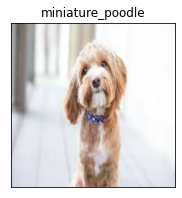

In [127]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)